In [94]:
import random
from Crypto.Util.number import bytes_to_long, long_to_bytes, inverse
from Crypto.Hash.SHA256 import SHA256Hash
from Crypto.Hash.SHA384 import SHA384Hash

# Prerequisites

- Elliptic curves
- ECDLP
- DSA
    - https://en.wikipedia.org/wiki/Digital_Signature_Algorithm

# Theory

- https://www.youtube.com/watch?v=6TI5YOpnrgI&t
- https://andrea.corbellini.name/2015/05/30/elliptic-curve-cryptography-ecdh-and-ecdsa/

The ECDSA is based on the DSA

**Notations**

- $E$ - Elliptic curve over $\mathbb{F}_p$
- $N = |E|$ - Order of the curve (Nr points)
- $G$ = a point on $E$ of large prime order $q <=>q*G = \mathcal{O}$
- $d$ = private key; $1 < d < q-1$
- $P = d*G $= public verification key

## Unhashed

**Algorithm**

Parameter creation
- A trusted party chooses a finite field $\mathbb{F}_p$, an elliptic curve $E(\mathbb{F}_p)$, and a point $(x_G, y_G) = G∈E(\mathbb{F}_p)$ of large prime order $q$

Key creation
- Choose a secret signing key $d$ with $1<d<q-1$
- compute $(x_P, y_P) = P = d*G \in E(\mathbb{F}_p)$
- publish $P$

Signing
- choose message $m$
- choose random element $k \in \{1,...,q-1\}$
- compute $(x_Q, y_Q) = Q = k*G$
- take $r = x_Q \ mod \ q$
    - if $r = 0$ choose another $k$
- compute $s = k^{-1}(m + rd) \ mod \ q$
    - if $s = 0$ choose another $k$
- publish $(r,s)$ = **signature**

Verification
- compute $u_1 = s^{-1}m \ mod \ q$
- compute $u_2 = s^{-1}r \ mod \ q$
- compute $(x_T, y_T) = T = u_1*G + u_2*P \in E(\mathbb{F}_p)$
- The signature must verify $x_T \ mod \ q = r$

**Proof**: the proof is under the hashed part

## Hashed


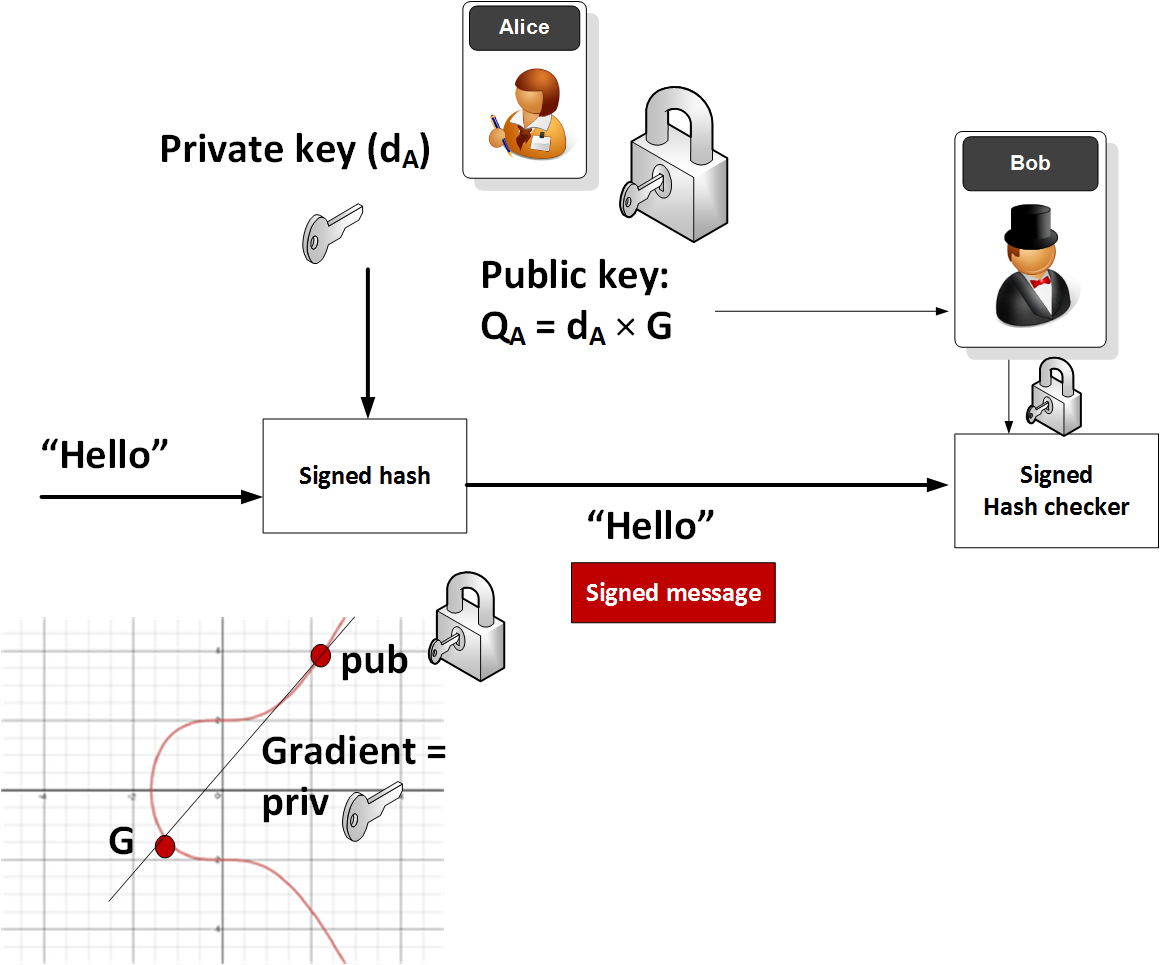

**Algorithm** (The elements might not correspond with the ones in the image)

Parameter creation
- A trusted party chooses a finite field $\mathbb{F}_p$, an elliptic curve $E(\mathbb{F}_p)$, and a point $(x_G, y_G) = G∈E(\mathbb{F}_p)$ of large prime order $q$

Key creation
- Choose a secret signing key $d$ with $1<d<q-1$
- compute $(x_P, y_P) = P = d*G \in E(\mathbb{F}_p)$
- publish P

Signing
- choose message $m$
- Compute the hash $e = HASH(m)$
- Let $h = L_q$ = leftmost bits of $e$
    - $L_q$ has a bitlength of the group order q
    - $h$ can be *greater* than $q$ but *not longer*
- choose random element $k \in \{1,...,q-1\}$
- compute $(x_Q, y_Q) = Q = k*G$
- take $r = x_Q \ mod \ q$
    - if $r = 0$ choose another $k$
- compute $s = k^{-1}(h + rd) \ mod \ q$
    - if $s = 0$ choose another $k$
- publish $(r,s)$ = **signature**
    - or $(r,-s \ mod \ q)$

Verification
- compute $e$ = HASH(m)
- let $h = L_q$ = leftmost bits of $e$
- compute $u_1 = s^{-1}h \ mod \ q$
- compute $u_2 = s^{-1}r \ mod \ q$
- compute $(x_T, y_T) = T = u_1*G + u_2*P \in E(\mathbb{F}_p)$
- The signature must verify $x_T \ mod \ q = r$


**Proof**
- the computations are $\ mod \ n$ here
- $T = u_1 * G + u_2 * P = u_1 * G + u_2d * G = (u_1 + u_2d) * G = (s^{-1}h + s^{-1}rd) * G = (h + rd)s^{-1} * G = (h + rd)(h + rd)^{-1}(k^{-1})^{-1} * G = k*G = Q$
- Therefore if $x_T == x_Q = r$ the signature is valid


**Remark**
- Knowing the private key $d$ will break the ecdsa
- you can find $d$ if you know $k$ for a signature
    - $s \equiv k^{-1}(h + rd) \ mod \ q <=> sk \equiv h + rd \ mod \ q <=> (sk - h)r^{-1} \equiv d \ mod q => $ you found $d$
    
- We will explore some attacks that find flaws in the way we choose the nonce $k$

# Code

In [2]:
# the P256 curve
p = 2^256- 2^224 +  2^192 + 2^96-1
a = -3 
b = 0x5ac635d8aa3a93e7b3ebbd55769886bc651d06b0cc53b0f63bce3c3e27d2604b
E = EllipticCurve(GF(p), [a, b])

In [9]:
G = E.gens()[0]
G

(38764697308493389993546589472262590866107682806682771450105924429005322578970 : 112597290425349970187225006888153254041358622497584092630146848080355182942680 : 1)

In [11]:
q = G.order() 

In [12]:
q

115792089210356248762697446949407573529996955224135760342422259061068512044369

## Unhashed

In [17]:
def key_creation(E, G, q):
    d = random.randint(1, q-1)
    P = d * G
    return d, P

In [18]:
d, P = key_creation(E, G, q)

In [41]:
def sign(m, E, G, q):
    k = random.randint(1, q-1)
    Q = k * G
    r = int(Q[0])
    if r == 0:
        print("Signature failed. Try again")
        return None
    
    s = ((inverse(k, q) * (m + d * r))) % q
    if s==0:
        print("Signature failed. Try again")
        return None
    return (r, s)

In [42]:
def verify(r, s, E, G, P, q):
    u1 = inverse(s, q) * m % q
    u2 = inverse(s, q) * r % q
    T = u1 * G + u2 * P
    return int(T[0]) == int(r)

In [43]:
m = bytes_to_long(b'secretmessage')
r, s = sign(m, E, G, q)

In [47]:
verify(r, s, E, G, P, q)

True

## Hashed

In [102]:
def sign_hashed(m, E, G, q):
    e = bytes_to_long(SHA384Hash(m).digest()) #hash -> m is bytes
    Lq = int(q).bit_length()
    #set the same bitlength
    z = e
    while z.bit_length() > Lq:
        z = z>>1
    k = random.randint(1, q-1)
    Q = k * G
    r = int(Q[0])
    if r == 0:
        print("Signature failed. Try again")
        return None
    
    s = ((inverse(k, q) * (z + d * r))) % q
    if s==0:
        print("Signature failed. Try again")
        return None
    return (r, s)

def verify_hashed(r, s, E, G, P, q):
    e = bytes_to_long(SHA384Hash(m).digest()) #hash -> m is bytes
    Lq = int(q).bit_length()
    #set the same bitlength
    z = e
    while z.bit_length() > Lq:
        z = z>>1
    u1 = inverse(s, q) * z % q
    u2 = inverse(s, q) * r % q
    T = u1 * G + u2 * P
    return int(T[0]) == int(r)

In [103]:
m = b'secretmessage'
r, s = sign_hashed(m, E, G, q)

In [104]:
verify_hashed(r, s, E, G, P, q)

True

## Library

- https://github.com/warner/python-ecdsa

In [75]:
from ecdsa import SigningKey,NIST192p,NIST224p,NIST256p,NIST384p,NIST521p,SECP256k1
import base64
import sys

In [105]:
m="secretmessage"
t = 1
E=NIST256p

In [106]:
sk = SigningKey.generate(curve=E) 
vk = sk.get_verifying_key()

In [107]:
signature = sk.sign(m.encode()) #different every run
signature 

b'\xaa\xad-\x8f7x\xba\xf4\xbf\xfc\xb3\xfa\xf9\xa7,61\x9a]\x81\xfbi\xdf\xbe\xe3\x96\xdeS\xec6\xad6\xf0\xbd\x88|\x086\xa5\xa3\xb2wn])\xa8\\w\x04\x11r\x11\x1c\xb4W\xf4t\xc9\xbf~Z\xcb\xb0\xdf'

In [108]:
vk.verify(signature, m.encode())

True

# Resources

- https://en.wikipedia.org/wiki/Digital_Signature_Algorithm
- https://en.wikipedia.org/wiki/Elliptic_Curve_Digital_Signature_Algorithm
- https://trustica.cz/en/2018/06/07/elliptic-curve-digital-signature-algorithm/
- Elliptic curves number theory and cryptography 2nd edition - P 179
- https://asecuritysite.com/encryption/ecdsa2